# Doc2Vec and Similarity Features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os
import math
from IPython.display import clear_output, display
import time
import warnings
warnings.filterwarnings('ignore')
import string
import heapq
import numpy
from heapq import nlargest
from operator import itemgetter

## Preliminaries 

In [2]:
# read the data
data = pd.read_pickle("./final_data.pkl")
articles = pd.read_pickle('./final_articles.pkl')

In [3]:
data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,date,cont_days,year,month,label,article_array
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,2017-07-17,11520,2017,7,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2018-03-17,11763,2018,3,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,2018-07-18,11886,2018,7,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2019-02-04,12087,2019,2,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2016-03-22,11038,2016,3,2,"[41099, 89899, 72543, 82644, 95344, 88361]"


In [4]:
articles.head()

,raw_articles,cleaned_articles,stemmed_articles,stemmed_stopwords_articles,tokenized_articles,cleaned_sentence,tokenized_cleaned_sentence
125385,Dr. Ben Carson: Welfare Benefactor?\nAn initia...,dr ben carson welfare benefactor an initially ...,dr ben carson welfar benefactor an initi unlik...,dr ben carson welfar benefactor initi unlik cl...,"[dr, ben, carson, welfar, benefactor, initi, u...","[dr ben carson welfar benefactor, initi unlik ...","[[dr, ben, carson, welfar, benefactor], [initi..."
32238,The World Factbook — Central Intelligence Agen...,the world factbook central intelligence agency...,the world factbook central intellig agenc the ...,world factbook central intellig agenc unit sta...,"[world, factbook, central, intellig, agenc, un...",[world factbook central intellig agenc unit st...,"[[world, factbook, central, intellig, agenc, u..."
16051,"1014 texaseducationagencypftexas\n\nEmails, La...",1014 texaseducationagencypftexas emails lauren...,1014 texaseducationagencypftexa email lauren c...,1014 texaseducationagencypftexa email lauren c...,"[1014, texaseducationagencypftexa, email, laur...",[1014 texaseducationagencypftexa email lauren ...,"[[1014, texaseducationagencypftexa, email, lau..."
118633,Clinton camp delays Weather Channel ad buy aft...,clinton camp delays weather channel ad buy aft...,clinton camp delay weather channel ad buy afte...,clinton camp delay weather channel ad buy back...,"[clinton, camp, delay, weather, channel, ad, b...",[clinton camp delay weather channel ad buy bac...,"[[clinton, camp, delay, weather, channel, ad, ..."
117945,Living with kangaroos\nKangaroos are appealing...,living with kangaroos kangaroos are appealing ...,live with kangaroo kangaroo are appeal wild an...,live kangaroo kangaroo appeal wild power nativ...,"[live, kangaroo, kangaroo, appeal, wild, power...",[live kangaroo kangaroo appeal wild power nati...,"[[live, kangaroo, kangaroo, appeal, wild, powe..."


## Doc2Vec 

### 1. Preprocess the Data

In [7]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy import spatial
import random

In [6]:
# %%time

# 2 minutes to run
# # create a label for every sentence based on article ID (eg. 12345-1, 12345-2, 12345-3 ... etc.)

# full_sentences_ID = []
# for i in range(articles.shape[0]):
#     sentence_ID_list = []
#     sentence_number = 0
#     sentences = articles.tokenized_cleaned_sentence.loc[articles.index[i]]
#     for u in range(len(sentences)):
#         sentence_ID = str(articles.index[i][0]) +  '-' + str(sentence_number)
#         sentence_number += 1
#         sentence_ID_list.append(sentence_ID)
#     full_sentences_ID.append(sentence_ID_list)
    
#     # print progress
#     progress = round((i/articles.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

In [7]:
# # combine the tokenized sentences with their ID
# articles_tok_sent = articles.tokenized_cleaned_sentence.to_frame()
# articles_tok_sent['sentence_ID'] = full_sentences_ID
# articles_tok_sent.head()

In [8]:
# %%time

# # combine the sentence list and index list ~ takes 1.5 hours to run

# article_sent_list = []
# article_sent_ID = []

# for i in range(articles_tok_sent.shape[0]):
#     one_article_sent = articles_tok_sent.tokenized_cleaned_sentence.loc[articles.index[i]]
#     article_sent_list = article_sent_list + one_article_sent
#     one_article_ID = articles_tok_sent.sentence_ID.loc[articles.index[i]]
#     article_sent_ID = article_sent_ID + one_article_ID
    
#     # print progress
#     progress = round((i/articles_tok_sent.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

In [9]:
# # create a data frame of the independent sentences and ID
# # create copies
# l1 = article_sent_list
# l2 = article_sent_ID
# # make dataframe
# article_information = pd.Series(l2).to_frame()
# article_information.columns = ['sentence_ID']
# article_information['sentences'] = l1
# # display it
# article_information.head()

In [10]:
# # save it to pickle
# article_information.to_pickle("./article_sentences_ind.pkl")

#### From Reading Pickle 

In [9]:
sentences_pkl = pd.read_pickle("./article_sentences_ind.pkl")

In [10]:
sentences_pkl.head()

,sentence_ID,sentences
0,125385-0,"[dr, ben, carson, welfar, benefactor]"
1,125385-1,"[initi, unlik, clearli, formid, contend, 2016,..."
2,125385-2,"[unlik, chri, christi, rand, paul, mike, hucka..."
3,125385-3,"[carson, becam, somewhat, overnight, sensat, f..."
4,125385-4,"[earliest, version, meme, date, least, decemb,..."


In [97]:
# extract the lists from the dataframes
sentence_ID_list = sentences_pkl.sentence_ID.tolist()
sentence_list = sentences_pkl.sentences.tolist()

In [14]:
# # average sentence size
# full_sent_size = []
# for i in range(sentences_pkl.shape[0]):
#     sentence_size = len(sentence_list[i])
#     full_sent_size.append(sentence_size)
# # sum(full_sent_size)/len(full_sent_size)
# max(full_sent_size)

##### Weird Article 

In [15]:
# full_sent_size.index(max(full_sent_size))

In [16]:
# sentences_pkl.loc[329509].iloc[0]

### 2. Prepare for Training

In [101]:
%%time
    
# create a list of claim index ranging from 0 - 15554
claim_range = range(0, 15555)
claim_index = []
for i in claim_range:
    claim_index.append(i)

# create a list of lists of data.tokenized_claim
tokenized_claims = []
for i in range(data.shape[0]):
    tokenized_claims.append(data.tokenized_claim[i])
    
# convert claim index to string to match the sentences ID
claim_str_index = list(map(str, claim_index))

# form full list for training
full_text_list = sentence_list + tokenized_claims
full_ID_list = sentence_ID_list + claim_str_index

CPU times: user 418 ms, sys: 16.4 ms, total: 435 ms
Wall time: 434 ms


In [102]:
# combine above 2 lists in to a dictionary for debugging
complete_data = dict(zip(full_ID_list, full_text_list))

In [104]:
complete_data['0']

['line', 'georg', 'orwel', 'novel', '1984', 'predict', 'power', 'smartphon']

### 3. Training

In [19]:
# %%time

# #create tagged data to train doc2vec w claim
# tagged_data = [TaggedDocument(words=full_text_list[i], tags=[full_ID_list[i]]) for i in range(len(full_text_list))]

CPU times: user 13.2 s, sys: 274 ms, total: 13.5 s
Wall time: 13.5 s


In [20]:
# %%time

# # 6 hours to run
# import multiprocessing
# n_cpu = multiprocessing.cpu_count()
# # setup training
# vec_size = 150
# model = Doc2Vec(dm = 1, vector_size = vec_size, min_count = 2, workers = n_cpu, epochs=30)
# # build vocab
# model.build_vocab(tagged_data)
# # train
# model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
# # save model
# model.save("30epoch_150vec.model")
# print("Model Saved")

Model Saved
CPU times: user 6h 52min 13s, sys: 54min 40s, total: 7h 46min 53s
Wall time: 5h 36min 24s


### 4. Find Similarities

In [12]:
%%time

# load the model
model = Doc2Vec.load("30epoch_150vec.model")

CPU times: user 11.5 s, sys: 2.82 s, total: 14.3 s
Wall time: 16.6 s


In [13]:
sentences_pkl.head()

,sentence_ID,sentences
0,125385-0,"[dr, ben, carson, welfar, benefactor]"
1,125385-1,"[initi, unlik, clearli, formid, contend, 2016,..."
2,125385-2,"[unlik, chri, christi, rand, paul, mike, hucka..."
3,125385-3,"[carson, becam, somewhat, overnight, sensat, f..."
4,125385-4,"[earliest, version, meme, date, least, decemb,..."


### 4.1 Finding Top 5 Sentences per Related Articles per Claim

In [23]:
# %%time

# # ~ 6 minutes to run
# # find the top 5 sentence ID from each related article with the highest similarity score with the claim

# final_best_sentences_ID = []
# for i in range(data.shape[0]): # iterating over every claim
#     one_claim_array = data.article_array.loc[i]
#     best_sentences_one_claim = []
#     for u in range(len(one_claim_array)): # iterating every article of one claim
#         one_article_ID = one_claim_array[u]
#         sent_list = articles.tokenized_cleaned_sentence.loc[str(one_article_ID)].iloc[0]
#         one_article_sim_list=[]
#         for y in range(len(sent_list)): #iterating over every sentence of one article
#             v1 = model.docvecs[str(i)]
#             sentence_number = str(str(one_article_ID) + '-' + str(y))
#             v2 = model.docvecs[sentence_number]
#             similarity = 1 - spatial.distance.cosine(v1, v2)
#             one_article_sim_list.append(similarity)
# #             print("ID: " + str(i) + " " + str(result))
#         a = numpy.array(one_article_sim_list)
#         best_sentences_one_article = heapq.nlargest(5, range(len(a)), a.take)   
#         best_sentences_one_claim.append(best_sentences_one_article)
#     final_best_sentences_ID.append(best_sentences_one_claim)
#     # print progress
#     progress = round((i/data.shape[0])*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

# # add it to the data frame
# data['best_sentences_ID'] = final_best_sentences_ID

progress: 99.99%
CPU times: user 6min, sys: 5.12 s, total: 6min 5s
Wall time: 6min


In [24]:
# %%time

# # ~ 2 minuts to run
# # calculate the top 5 similarity scores

# end = data.shape[0]
# # end = 2
# avg_sim_for_one_claim_list = []
# avg_sim_one_claim = []
# full_sentence_ID = []
# for i in range(end): # per row
#     one_claim_articles_ID = data.article_array.loc[i]
#     one_claim_sentences_ID = data.best_sentences_ID.loc[i]
#     avg_sim_for_one_article = []
#     article_sentence_ID = []
# #     print("claim: " + str(i))
#     for u in range(len(one_claim_articles_ID)): # article_array index
#         sim_for_one_article = []
#         sentence_ID_list = []
#         for y in range(len(one_claim_sentences_ID[u])): # sentence ID index      
#             sentence_ID = str(one_claim_articles_ID[u]) + '-' + str(data.best_sentences_ID.loc[i][u][y])
#             sentence_ID_list.append(sentence_ID)
#             # calculate sim score
#             v1 = model.docvecs[str(i)]
#             v2 = model.docvecs[sentence_ID]
#             similarity = 1 - spatial.distance.cosine(v1, v2)
#             # similarity between claim and each sentence is calculated
#             sim_for_one_article.append(similarity)
# #             print(str(sentence_ID) + ": " + str(similarity))
#         # the similarity between claim and each sentence per article is averaged
#         avg_sim = sum(sim_for_one_article)/len(sim_for_one_article)
#         avg_sim_for_one_article.append(avg_sim)
# #         print("")
#         article_sentence_ID.append(sentence_ID_list)
    
#     # create a list of sentence ID's
#     full_sentence_ID.append(article_sentence_ID)
    
#     #calculate average scores for each claim
#     avg_sim_ = sum(avg_sim_for_one_article)/len(avg_sim_for_one_article)
#     avg_sim_one_claim.append(avg_sim_)
    
#     # a list of lists, big list per claim, and small list per article
#     avg_sim_for_one_claim_list.append(avg_sim_for_one_article)
    
#     # print progress
#     progress = round((i/end)*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

progress: 99.99%
CPU times: user 1min 11s, sys: 3.31 s, total: 1min 14s
Wall time: 1min 11s


In [25]:
# # add to data frame
# data['full_sentence_ID'] = full_sentence_ID
# data['avg_sentence_sim'] = avg_sim_for_one_claim_list
# data['avg_sim_score'] = avg_sim_one_claim

### 4.2 Finding Top 5 Sentences amongst all Related Articles per Claim

In [26]:
# %%time

# # finding top 5 sentences amongst all relateld articles per claim

# end = data.shape[0]
# # end = 10

# sim_score_dict = {}

# final_top_sentences = []

# for i in range(end):
#     top_sentence_list = data.full_sentence_ID.loc[i]
#     sim_score_tuple = []
#     for u in range(len(top_sentence_list)):
#         for y in range(len(top_sentence_list[u])):
#             sentence_ID = top_sentence_list[u][y]
#             # calculate sim score
#             v1 = model.docvecs[str(i)]
#             v2 = model.docvecs[sentence_ID]
#             similarity = 1 - spatial.distance.cosine(v1, v2)
# #             sim_for_one_claim.append(similarity)
#             sim_score_tuple.append(tuple((sentence_ID, similarity)))
# #             print(str(sentence_ID) + ": " + str(similarity))
#     a = nlargest(5, sim_score_tuple, key=itemgetter(1))
#     top_sentences = [q[0] for q in a]
#     # list of lists: final top 5 sentences amongst all related articles per claim
#     final_top_sentences.append(top_sentences)
    
#     # print progress
#     progress = round((i/end)*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

# # save it to the dataframe
# data['top_5_sentences'] = final_top_sentences

progress: 99.99%
CPU times: user 48.5 s, sys: 2.73 s, total: 51.2 s
Wall time: 48.6 s


In [27]:
# %%time

# # average similarity scores of top 5 sentences amongst all relateld articles per claim

# end = data.shape[0]
# # end = 10

# total_avg_sim = []

# for i in range(end):
#     top_sentence_list = data.top_5_sentences.loc[i]
#     top_sim_scores = []
#     for u in range(len(top_sentence_list)):
#         sentence_ID = top_sentence_list[u]
#         # calculate sim score
#         v1 = model.docvecs[str(i)]
#         v2 = model.docvecs[sentence_ID]
#         similarity = 1 - spatial.distance.cosine(v1, v2)       
#         top_sim_scores.append(similarity)
        
#     avg_sim = sum(top_sim_scores)/len(top_sim_scores)
#     total_avg_sim.append(avg_sim)
    
#     # print progress
#     progress = round((i/end)*100,2)
#     clear_output(wait=True)
#     print("progress: " + str(progress) + "%")

# # save it to the dataframe
# data['top5_avg_sim'] = total_avg_sim

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
# data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,date,cont_days,year,month,label,article_array,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score,top_5_sentences,top5_avg_sim
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,2017-07-17,11520,2017,7,0,"[122094, 122580, 130685, 134765]","[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311,"[122094-0, 122580-11, 122094-21, 122094-15, 12...",0.291527
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2018-03-17,11763,2018,3,2,"[106868, 127320, 128060]","[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489,"[106868-11, 106868-7, 127320-22, 127320-24, 12...",0.400307
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,2018-07-18,11886,2018,7,1,"[132130, 132132, 149722]","[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089,"[132132-3, 132132-6, 132132-59, 132132-60, 132...",0.642181
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2019-02-04,12087,2019,2,2,"[123254, 123418, 127464]","[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903,"[127464-222, 123254-51, 123254-41, 123254-70, ...",0.775002
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2016-03-22,11038,2016,3,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560,"[41099-168, 95344-259, 95344-247, 95344-74, 95...",0.547029


In [29]:
# # save to data frame
# data.to_pickle("./data_sentence_simscore.pkl")

In [89]:
# model.docvecs.most_similar('0')

[('115280-38', 0.6487554311752319),
 ('68326-486', 0.6099780201911926),
 ('106754-60', 0.6012491583824158),
 ('149160-47', 0.5995368957519531),
 ('76075-65', 0.5932543873786926),
 ('90436-8', 0.5900030732154846),
 ('74850-8', 0.5896259546279907),
 ('55964-12', 0.5870769023895264),
 ('94499-3', 0.5841438174247742),
 ('77645-433', 0.5817995071411133)]

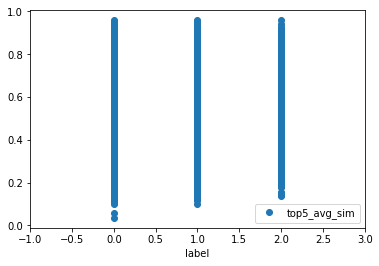

In [36]:
# # plot the average scores of each label
# _ = data.plot(x='label', y='top5_avg_sim', style='o')
# _ = plt.xlim(-1, 3)

In [38]:
# model.docvecs['122094-20']

In [42]:
# v1 = model.docvecs['0']
# v2 = model.docvecs['122094-0']
# result = 1 - spatial.distance.cosine(v1, v2)
# result

0.347765177488327

### 5. Feature Extraction/Encoding

In [20]:
# load the files
full_data = pd.read_pickle("./data_sentence_simscore.pkl")
full_data2 = pd.read_pickle("./data_simscore.pkl")

In [21]:
full_data.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,date,cont_days,year,month,label,article_array,best_sentences_ID,full_sentence_ID,avg_sentence_sim,avg_sim_score,top_5_sentences,top5_avg_sim
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,2017-07-17,11520,2017,7,0,"[122094, 122580, 130685, 134765]","[[0, 21, 15, 20, 10], [11, 24, 12, 13, 26], [3...","[[122094-0, 122094-21, 122094-15, 122094-20, 1...","[0.26672267615795137, 0.24059542417526245, 0.1...",0.185311,"[122094-0, 122580-11, 122094-21, 122094-15, 12...",0.291527
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2018-03-17,11763,2018,3,2,"[106868, 127320, 128060]","[[11, 7, 13, 3, 4], [22, 24, 0, 1, 19], [0, 8,...","[[106868-11, 106868-7, 106868-13, 106868-3, 10...","[0.382437926530838, 0.374161022901535, 0.28886...",0.348489,"[106868-11, 106868-7, 127320-22, 127320-24, 12...",0.400307
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,2018-07-18,11886,2018,7,1,"[132130, 132132, 149722]","[[22, 30, 8, 32, 29], [3, 6, 59, 60, 83], [6, ...","[[132130-22, 132130-30, 132130-8, 132130-32, 1...","[0.45887559056282046, 0.6421806216239929, 0.29...",0.464089,"[132132-3, 132132-6, 132132-59, 132132-60, 132...",0.642181
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2019-02-04,12087,2019,2,2,"[123254, 123418, 127464]","[[51, 41, 70, 103, 30], [107, 102, 61, 191, 98...","[[123254-51, 123254-41, 123254-70, 123254-103,...","[0.7696409344673156, 0.7453237056732178, 0.755...",0.756903,"[127464-222, 123254-51, 123254-41, 123254-70, ...",0.775002
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2016-03-22,11038,2016,3,2,"[41099, 89899, 72543, 82644, 95344, 88361]","[[168, 170, 45, 191, 32], [10, 12, 4, 16, 25],...","[[41099-168, 41099-170, 41099-45, 41099-191, 4...","[0.4999494135379791, 0.408842134475708, 0.3396...",0.411560,"[41099-168, 95344-259, 95344-247, 95344-74, 95...",0.547029


In [169]:
full_data2.head()

,raw_claim,cleaned_claim,stemmed_claims,stemmed_stopword_claims,tokenized_claim,claimant,date,cont_days,year,month,label,article_array,average_score,similarity_variance,max_similarity
0,A line from George Orwell's novel 1984 predict...,a line from george orwells novel 1984 predicts...,a line from georg orwel novel 1984 predict the...,line georg orwel novel 1984 predict power smar...,"[line, georg, orwel, novel, 1984, predict, pow...",Unknown,2017-07-17,11520,2017,7,0,"[122094, 122580, 130685, 134765]",0.307869,0.006805,0.447643
1,Maine legislature candidate Leslie Gibson insu...,maine legislature candidate leslie gibson insu...,main legislatur candid lesli gibson insult par...,main legislatur candid lesli gibson insult par...,"[main, legislatur, candid, lesli, gibson, insu...",Unknown,2018-03-17,11763,2018,3,2,"[106868, 127320, 128060]",0.684023,0.003215,0.739247
2,A 17-year-old girl named Alyssa Carson is bein...,a 17yearold girl named alyssa carson is being ...,a 17yearold girl name alyssa carson is be trai...,17yearold girl name alyssa carson train nasa b...,"[17yearold, girl, name, alyssa, carson, train,...",Unknown,2018-07-18,11886,2018,7,1,"[132130, 132132, 149722]",0.564941,0.029931,0.692960
3,In 1988 author Roald Dahl penned an open lette...,in 1988 author roald dahl penned an open lette...,in 1988 author roald dahl pen an open letter u...,1988 author roald dahl pen open letter urg par...,"[1988, author, roald, dahl, pen, open, letter,...",Unknown,2019-02-04,12087,2019,2,2,"[123254, 123418, 127464]",0.648540,0.003423,0.724962
4,"When it comes to fighting terrorism, ""Another ...",when it comes to fighting terrorism another th...,when it come to fight terror anoth thing we kn...,come fight terror anoth thing know doe work ba...,"[come, fight, terror, anoth, thing, know, doe,...",Hillary Clinton,2016-03-22,11038,2016,3,2,"[41099, 89899, 72543, 82644, 95344, 88361]",0.602941,0.020164,0.780002


### 5.1 Feature Encode the Claims

In [93]:
# create a list of lists containing the claim's vector
claim_vectors = []
for i in range(0, 15555):
    claim_vectors.append(model.docvecs[str(i)])

# create a list of column names
column_name_list = []
for i in range(0,150):
    column_name = "claim_vec_" + str(i)
    column_name_list.append(column_name)

# turn the claim vectors in to a dataframe and rename the columns accordingly
claim_features = pd.DataFrame.from_records(claim_vectors)
claim_features.columns = column_name_list

In [94]:
claim_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,claim_vec_140,claim_vec_141,claim_vec_142,claim_vec_143,claim_vec_144,claim_vec_145,claim_vec_146,claim_vec_147,claim_vec_148,claim_vec_149
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.283741,-0.166108,-0.125862,0.316487,-0.086704,-0.015346,0.263394,0.236137,0.191386,-0.144861
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,-0.216366,0.181766,0.237602,0.279045,-0.126447,-0.209171,-0.191039,0.158190,-0.066281,-0.247980
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,-0.155529,-0.015081,0.274674,0.272769,-0.237696,0.130785,-0.032134,0.104650,0.257081,0.016224
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,-0.336580,-0.263726,-0.080669,0.152311,-0.093220,0.300876,-0.068453,0.307259,0.150425,-0.206309
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,-0.029561,-0.171704,0.290350,0.440742,-0.249992,0.430053,-0.086707,0.252833,-0.295727,0.226280


### 5.2 Feature Encode the Top 5 Related Article Sentencese for Each Claim 

In [156]:
%%time

end = full_data.shape[0]
# end = 1
full_sentence_vector_list = []
for i in range(end):
    top_5_sentences = full_data.top_5_sentences.loc[i]
    sentence_vector_list = []
    for u in range(len(top_5_sentences)):
        sentence_ID = full_data.top_5_sentences.loc[i][u]
        sentence_vector = model.docvecs[sentence_ID]
        sentence_vector_list.extend(sentence_vector)
    full_sentence_vector_list.append(sentence_vector_list)

    # print progress
    progress = round((i/end)*100,2)
    clear_output(wait=True)
    print("progress: " + str(progress) + "%")

# create column names
complete_column_name=[]
for i in range(1, 6):
    column_name_list = []
    for u in range(0,150):
        column_name = "sent_" + str(i) + "vec_" + str(u)
        column_name_list.append(column_name)
    complete_column_name.extend(column_name_list)

# convert full sentence features in to dataframe and name the columns accordingly
sentence_features = pd.DataFrame.from_records(full_sentence_vector_list)
sentence_features.columns = complete_column_name

progress: 99.99%
CPU times: user 24.5 s, sys: 2.7 s, total: 27.2 s
Wall time: 24.2 s


In [157]:
sentence_features.head()

,sent_1vec_0,sent_1vec_1,sent_1vec_2,sent_1vec_3,sent_1vec_4,sent_1vec_5,sent_1vec_6,sent_1vec_7,sent_1vec_8,sent_1vec_9,...,sent_5vec_140,sent_5vec_141,sent_5vec_142,sent_5vec_143,sent_5vec_144,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149
0,0.010075,-0.034665,0.158326,0.114454,0.167062,-0.325514,0.343727,-0.181544,0.427879,-0.064174,...,-0.329464,-0.123360,-0.106719,0.596236,-0.361782,-0.154024,0.078335,0.041940,-0.059460,0.239629
1,0.537097,0.346272,-0.127193,0.008937,-0.498761,0.209842,-0.136562,-0.121760,0.598921,0.272825,...,0.310716,1.026762,1.642795,0.402427,-0.656952,-0.680550,1.451327,0.068513,0.286796,0.028587
2,-0.034549,0.159652,0.068537,-0.108595,0.401951,0.025913,0.490867,-0.182542,0.126992,0.227730,...,-0.187836,-0.225113,0.046499,0.118527,0.053234,0.126584,-0.112338,0.300140,0.125310,0.023155
3,-0.006104,0.218761,-0.044763,-0.014197,0.140955,0.030794,0.227532,-0.064394,0.077120,0.073692,...,-0.184586,-0.138933,0.027737,0.214644,-0.101030,0.155582,0.019132,0.178928,0.125431,0.017242
4,0.143222,0.262105,-0.407402,-0.173036,-0.196569,0.068167,0.154569,-0.175273,0.005277,0.168737,...,-0.060368,-0.066583,0.038418,0.146584,-0.051212,0.113704,-0.006178,0.114713,0.056479,0.011474


### 5.3 Feature Encode the Similarity Scores 

In [163]:
sim_score_features = pd.concat([full_data2.average_score, full_data2.similarity_variance, full_data2.max_similarity, full_data.avg_sim_score, full_data.top5_avg_sim], axis=1)
sim_score_features.columns = ['art_claim_sim', "art_claim_var", "art_claim_max_sim", "avg_sent_sim", "avg_5_sent_sim"]

In [164]:
sim_score_features.head()

,art_claim_sim,art_claim_var,art_claim_max_sim,avg_sent_sim,avg_5_sent_sim
0,0.307869,0.006805,0.447643,0.185311,0.291527
1,0.684023,0.003215,0.739247,0.348489,0.400307
2,0.564941,0.029931,0.692960,0.464089,0.642181
3,0.648540,0.003423,0.724962,0.756903,0.775002
4,0.602941,0.020164,0.780002,0.411560,0.547029


### 5.4 Combine All Features (Claim Vector, Top 5 Related Sentences Vector, Similarity Scores)

In [165]:
final_similiarity_sentences_features = pd.concat([claim_features, sentence_features, sim_score_features], axis=1)

In [168]:
final_similiarity_sentences_features.head()

,claim_vec_0,claim_vec_1,claim_vec_2,claim_vec_3,claim_vec_4,claim_vec_5,claim_vec_6,claim_vec_7,claim_vec_8,claim_vec_9,...,sent_5vec_145,sent_5vec_146,sent_5vec_147,sent_5vec_148,sent_5vec_149,art_claim_sim,art_claim_var,art_claim_max_sim,avg_sent_sim,avg_5_sent_sim
0,-0.212091,0.127670,0.106502,0.391641,0.303139,-0.248252,0.236494,0.104728,-0.271278,0.377465,...,-0.154024,0.078335,0.041940,-0.059460,0.239629,0.307869,0.006805,0.447643,0.185311,0.291527
1,0.512708,0.203220,0.151913,-0.307748,-0.426895,0.143223,0.293944,-0.129267,0.512433,0.322509,...,-0.680550,1.451327,0.068513,0.286796,0.028587,0.684023,0.003215,0.739247,0.348489,0.400307
2,0.145354,0.215115,0.078994,0.009343,0.213732,-0.022070,0.126207,-0.130475,-0.093990,0.159534,...,0.126584,-0.112338,0.300140,0.125310,0.023155,0.564941,0.029931,0.692960,0.464089,0.642181
3,-0.138208,0.415532,-0.018799,0.094876,0.292537,-0.157601,0.552872,-0.179123,0.080213,-0.131668,...,0.155582,0.019132,0.178928,0.125431,0.017242,0.648540,0.003423,0.724962,0.756903,0.775002
4,0.126634,0.311318,-0.125836,-0.143917,-0.092023,-0.118011,-0.178362,-0.358138,0.349950,-0.148357,...,0.113704,-0.006178,0.114713,0.056479,0.011474,0.602941,0.020164,0.780002,0.411560,0.547029


In [170]:
# save the final features to a pickle
final_similiarity_sentences_features.to_pickle("./doc2vec_features.pkl")